In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [3]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2020-04-16 14:53:59--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 2607:f8b0:400c:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-04-16 14:53:59 (119 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [4]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1605)              162105    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
______________________________________________

In [5]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 51s 105ms/step - loss: 6.9159 - accuracy: 0.0210
Epoch 2/100
484/484 [==============================] - 51s 106ms/step - loss: 6.4989 - accuracy: 0.0211
Epoch 3/100
484/484 [==============================] - 51s 105ms/step - loss: 6.4089 - accuracy: 0.0234
Epoch 4/100
484/484 [==============================] - 51s 105ms/step - loss: 6.2921 - accuracy: 0.0290
Epoch 5/100
484/484 [==============================] - 51s 105ms/step - loss: 6.2010 - accuracy: 0.0369
Epoch 6/100
484/484 [==============================] - 51s 105ms/step - loss: 6.1100 - accuracy: 0.0368
Epoch 7/100
484/484 [==============================] - 51s 105ms/step - loss: 6.0380 - accuracy: 0.0418
Epoch 8/100
484/484 [==============================] - 51s 105ms/step - loss: 5.9536 - accuracy: 0.0456
Epoch 9/100
484/484 [==============================] - 50s 104ms/step - loss: 5.8594 - accuracy: 0.0491
Epoch 10/100
484/484 [==============================] - 51s 105m

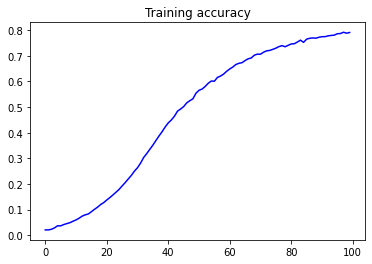

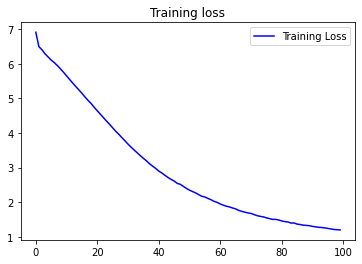

In [6]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [8]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope and show your sight ' go part was life so well doth shown erred grow parts sweet memory lie in heaven find life so was call so be so lips to decay go spite of score spent gone doth new deem'd grow dead spent place well form bearing days dote allow arising staineth grow pain prove cure change all thy head of show thee thee so good part live show thee thee what that am blessed green my form away well face well loss 'tis loss 'tis loss 'tis done wilt live loves thou art alone respect forth such strife
